In [485]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import seaborn as sns

sns.set()

# Bringing the data into Dataframes

Load the data from each csv and tsv into individual pandas dataframes

In [486]:
#Load the csv files
the_movie_db_df = pd.read_csv('zippedData/tmdb.movies.csv')
gross_df = pd.read_csv('zippedData/bom.movie_gross.csv')
tomato_movieinfo_df = pd.read_csv('zippedData/rt.movie_info.tsv', sep = '\t')
tomato_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv', sep = '\t', encoding = 'latin-1')
tn_movie_budgets_db = pd.read_csv('zippedData/tn.movie_budgets.csv')

Connect to the IM.DB via sqlite3

In [487]:
#Created connection object for reading from the database
conn = sqlite3.connect('zippedData/im.db')

## Compare average rating to profit
in order to determine if higher rated movies profit more. This will be useful since if there if a strong correlation, then voting average can be used as a stand-in for actual profits. Then, you can make comparisons of ratings vs. genre, etc to make statements about profitability.

In [488]:
#Convert money string into money integer so it can be used as a number.
def money_to_int(string):
    return int(string.replace('$', '').replace(',', ''))

In [489]:
#Replace the name in tn movie db so that it can be merged with the movie db dataset (column name must be the same)
tn_movie_budgets_db = tn_movie_budgets_db.rename({'movie': "title"}, axis='columns')
tn_movie_budgets_db_merge_budgets = tn_movie_budgets_db.merge(the_movie_db_df, how='inner',on='title')
tn_movie_budgets_db_merge_budgets['ww_float_gross'] = tn_movie_budgets_db_merge_budgets['worldwide_gross'].map(money_to_int)
tn_movie_budgets_db_merge_budgets['float_budget'] = tn_movie_budgets_db_merge_budgets['production_budget'].map(money_to_int)
tn_movie_budgets_db_merge_budgets['profit'] = tn_movie_budgets_db_merge_budgets['ww_float_gross'] - tn_movie_budgets_db_merge_budgets['float_budget']


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The correlation between average rating and profits is: 0.1971


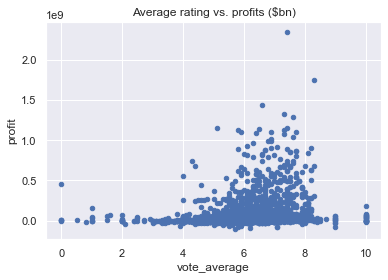

In [490]:
#Plot profit vs. average rating in a scatter plot and see if there is a strong linear relationship between the two.
fig, ax = plt.subplots()
tn_movie_budgets_db_merge_budgets.plot.scatter('vote_average','profit', ax = ax)
vote_vs_profit_correlation = tn_movie_budgets_db_merge_budgets[['vote_average','profit']].corr().iloc[0,1]
print("The correlation between average rating and profits is: " + str(round(tn_movie_budgets_db_merge_budgets[['vote_average','profit']].corr().iloc[0,1],4)))
plt.title('Average rating vs. profits ($bn)');

### Determine percentage of fresh vs. not fresh movies by genre within the rotten tomatoes dataset.

Steps:

1. Need to clean the genre column in the Rotten Tomatoes movie info data set.
2. Make a set of columns for each genre listing true/false for each entry to identify which genre the movie is in.
3. Build a dictionary that prints 

In [491]:
#Get list of unique genres
tomato_movieinfo_df.dropna(subset=['genre'],inplace=True)
unique_genres = []
for genres in list(tomato_movieinfo_df['genre']):
    for genre in genres.split('|'):
        unique_genres.append(genre)
unique_genres = set(unique_genres)

In [492]:
#This cell creates a boolean matrix representing the genres that are in each movie. That way, movies can be filtered by a single genre
#and statements can be made on a genre-by-genre basis.
for genre in unique_genres:
    tomato_movieinfo_df[genre] = tomato_movieinfo_df['genre'].map(lambda x: genre in x)

In [493]:
#MERGE the two rotten tomatoes databases.
tomato_movieinfo_df_reviews_merged = tomato_movieinfo_df.merge(tomato_reviews_df, on = 'id', how = 'inner')

In [494]:
#Creates a "fresh_by_genre" dictionary that lists the ratio fresh/(fresh + not fresh), or the percentage of movies in that genre that are considered "fresh".
#Useful measure to see how well received different genres are, in general, by Rotten Tomatoes.
fresh_by_genre = {}

for genre in unique_genres:
    num_fresh = tomato_movieinfo_df_reviews_merged.groupby(['fresh',genre]).count().xs('fresh').iloc[1,0]
    num_rotten = tomato_movieinfo_df_reviews_merged.groupby(['fresh',genre]).count().xs('rotten').iloc[1,0]
    percent_fresh = num_fresh/(num_rotten+num_fresh)
    fresh_by_genre[genre] = percent_fresh

In [495]:
#Sorts the fresh_by_genre dict by their values
fresh_by_genre = dict(sorted(fresh_by_genre.items(), key=lambda item: item[1]))

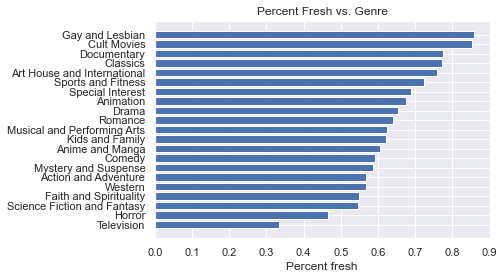

In [496]:
#plotting the dict as a bar chart
fig, ax = plt.subplots()
keys = list(fresh_by_genre.keys())
values = list(fresh_by_genre.values())
plt.barh(keys,values)
plt.xlabel('Percent fresh')
plt.title('Percent Fresh vs. Genre');

In [497]:
#Covert to integer values and calculate profits.
tn_movie_budgets_db['worldwide_gross'] = tn_movie_budgets_db['worldwide_gross'].map(money_to_int)
tn_movie_budgets_db['production_budget'] = tn_movie_budgets_db['production_budget'].map(money_to_int)
tn_movie_budgets_db['domestic_gross'] = tn_movie_budgets_db['domestic_gross'].map(money_to_int)
tn_movie_budgets_db['worldwide_profits'] = tn_movie_budgets_db['worldwide_gross'] - tn_movie_budgets_db['production_budget']
tn_movie_budgets_db.sort_values('worldwide_profits', ascending= False).head(10)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,worldwide_profits
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864
66,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794
26,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897
260,61,"Jul 15, 2011",Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157,1216693157
41,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224
112,13,"Jun 22, 2018",Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,1135772799


In [498]:
#This cell creates a column 'ratio' which is the ratio of worldwide gross to budget. Probably need to clean the data more after this.
tn_movie_budgets_db['release_date'] = tn_movie_budgets_db['release_date'].map(lambda x: str(pd.to_datetime(x)))
tn_unflated_db = tn_movie_budgets_db

tn_unflated_db['ratio'] = tn_unflated_db['worldwide_gross'] / tn_unflated_db['production_budget']

tn_unflated_db.replace(to_replace = 0, value = np.nan, inplace = True)
tn_unflated_db.dropna(inplace = True)
tn_unflated_db.sort_values('ratio', ascending = False).head()

tn_unflated_df = tn_unflated_db
tn_unflated_df.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,worldwide_profits,ratio
0,1,2009-12-18 00:00:00,Avatar,425000000,760507625.0,2.776345e+09,2351345279,6.532577
1,2,2011-05-20 00:00:00,Pirates of the Caribbean: On Stranger Tides,410600000,241063875.0,1.045664e+09,635063875,2.546673
2,3,2019-06-07 00:00:00,Dark Phoenix,350000000,42762350.0,1.497624e+08,-200237650,0.427892
3,4,2015-05-01 00:00:00,Avengers: Age of Ultron,330600000,459005868.0,1.403014e+09,1072413963,4.243841
4,5,2017-12-15 00:00:00,Star Wars Ep. VIII: The Last Jedi,317000000,620181382.0,1.316722e+09,999721747,4.153696


## Most Profitable Genres

Take a look at each genre's spread of profit ratio to see the most profitable genres

In [499]:
#Reload data for consistency
tn_movie_budgets_db = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [500]:
#Remove movies with an extremely low budget, as Microsoft has money to spend (and account for outliers)
tn_unflated_db.loc[tn_unflated_db['production_budget'] >= 400000].sort_values('ratio', ascending = False).head(15)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,worldwide_profits,ratio
5492,93,2009-09-25 00:00:00,Paranormal Activity,450000,107918810.0,194183034.0,193733034,431.517853
5406,7,1999-07-14 00:00:00,The Blair Witch Project,600000,140539099.0,248300000.0,247700000,413.833333
5346,47,1942-08-13 00:00:00,Bambi,858000,102797000.0,268000000.0,267142000,312.354312
5210,11,1976-11-21 00:00:00,Rocky,1000000,117235147.0,225000000.0,224000000,225.000000
5372,73,1973-08-11 00:00:00,American Graffiti,777000,115000000.0,140000000.0,139223000,180.180180
5117,18,1937-12-21 00:00:00,Snow White and the Seven Dwarfs,1488000,184925486.0,184925486.0,183437486,124.277880
5357,58,1971-01-01 00:00:00,Billy Jack,800000,98000000.0,98000000.0,97200000,122.500000
5507,8,2004-06-11 00:00:00,Napoleon Dynamite,400000,44540956.0,46122713.0,45722713,115.306782
5430,31,2004-08-06 00:00:00,Open Water,500000,30500882.0,55518641.0,55018641,111.037282
5424,25,1980-05-09 00:00:00,Friday the 13th,550000,39754601.0,59754601.0,59204601,108.644729


### Join this ratio table with Genres

First fetch IMDB data that has the movie genres

In [501]:
table_name_query = """SELECT *
FROM movie_basics"""

imdb_movie_basics_df = pd.read_sql(table_name_query, conn)


Filter the movie basics dataframe by original title

In [502]:
table_name_query = """SELECT *
FROM movie_akas"""

imdb_movie_akas_df = pd.read_sql(table_name_query, conn)

In [503]:
imdb_original_titles_df = imdb_movie_akas_df.loc[imdb_movie_akas_df['is_original_title'] == 1]
imdb_original_titles_df.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
38,tt0369610,45,Jurassic World,None,None,original,None,1.0
80,tt0401729,7,John Carter,None,None,original,None,1.0
83,tt10010134,1,Versailles Rediscovered - The Sun King's Vanis...,None,None,original,None,1.0
86,tt10027708,1,Miguelito - Canto a Borinquen,None,None,original,None,1.0
90,tt10050722,1,Thing I Don't Get,None,None,original,None,1.0


### Create the Ratio-Genre Table

Create a true/false matrix of genres for each movie to allow for easy filtering

In [504]:
original_titles_df = pd.merge(imdb_movie_basics_df, imdb_original_titles_df, how = 'inner', on = 'movie_id')

indices = original_titles_df.loc[original_titles_df['runtime_minutes'] < 60.0].index

original_titles_df.drop(indices, axis = 0, inplace = True)


In [505]:
original_titles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42342 entries, 0 to 44698
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           42342 non-null  object 
 1   primary_title      42342 non-null  object 
 2   original_title     42342 non-null  object 
 3   start_year         42342 non-null  int64  
 4   runtime_minutes    38353 non-null  float64
 5   genres             41861 non-null  object 
 6   ordering           42342 non-null  int64  
 7   title              42342 non-null  object 
 8   region             6 non-null      object 
 9   language           4 non-null      object 
 10  types              42342 non-null  object 
 11  attributes         0 non-null      object 
 12  is_original_title  42342 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 4.5+ MB


In [506]:
tn_unflated_db.rename(columns = {'title' : 'primary_title'}, inplace = True)

In [507]:
tn_unflated_db['release_year'] = tn_unflated_db['release_date'].map(lambda x: int(x[:4]))

In [508]:
original_titles_df.shape

(42342, 13)

In [509]:
ratio_genre_df = pd.merge(tn_unflated_db, original_titles_df, how = 'inner', left_on = ['primary_title', 'release_year'], right_on = ['primary_title', 'start_year'])

In [510]:
ratio_genre_df.dropna(subset=['genres'],inplace=True)
unique_genres = []
for genres in list(ratio_genre_df['genres']):
    for genre in genres.split(','):
        unique_genres.append(genre)
unique_genres = set(unique_genres)

In [511]:
for genre in unique_genres:
    ratio_genre_df[genre] = ratio_genre_df['genres'].map(lambda x: genre in x)

ratio_genre_df.columns

Index(['id', 'release_date', 'primary_title', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'worldwide_profits', 'ratio',
       'release_year', 'movie_id', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'ordering', 'title', 'region', 'language',
       'types', 'attributes', 'is_original_title', 'Western', 'Romance',
       'Animation', 'War', 'Action', 'Drama', 'Crime', 'Horror', 'Biography',
       'Family', 'Fantasy', 'Adventure', 'Documentary', 'History', 'Musical',
       'Sci-Fi', 'Mystery', 'Thriller', 'Music', 'Sport', 'Comedy'],
      dtype='object')

In [512]:
genre_tf_count = ratio_genre_df.loc[:,'Western': 'Comedy'].sum()
genre_tf_count

Western          9
Romance        175
Animation       95
War             16
Action         403
Drama          642
Crime          205
Horror         142
Biography      128
Family          84
Fantasy        111
Adventure      333
Documentary     24
History         38
Musical          6
Sci-Fi         125
Mystery        110
Thriller       225
Music           51
Sport           31
Comedy         463
dtype: int64

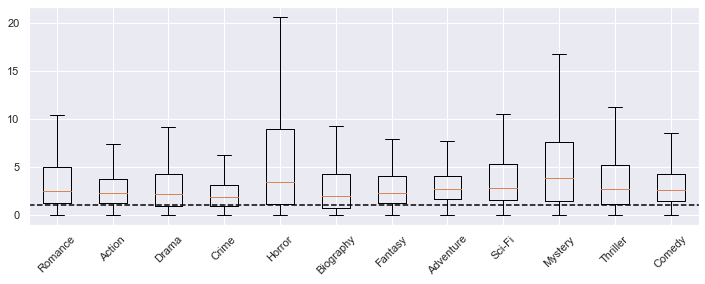

In [513]:
fig, ax = plt.subplots()

boxplot_list = []
index_list = []
median_dict = {}
for index in genre_tf_count.index:
   if genre_tf_count[index] > 100:
      index_list.append(index)
      median_dict[index] = ratio_genre_df.loc[ratio_genre_df[index] == True]['ratio'].median()
      boxplot_list.append(ratio_genre_df.loc[ratio_genre_df[index] == True]['ratio'])

ax.boxplot(boxplot_list, showfliers = False)
ax.axhline(y = 1, c = '#000000', linestyle = '--')
ax.set_xticklabels(index_list, rotation = 45)

fig.set_figwidth(12)


plt.show()


In [514]:
median_dict = sorted(median_dict.items(), key = lambda x: x[1])

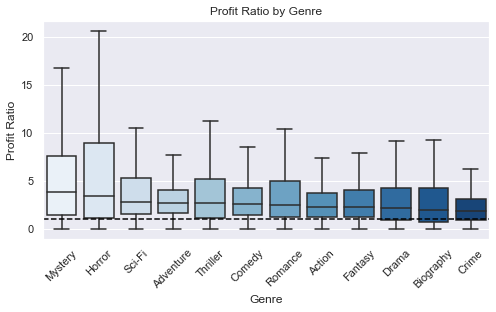

In [515]:
fig, ax = plt.subplots()

index_list = []
boxplot_list = []
for genre, value in reversed(median_dict):
   index_list.append(genre)
   boxplot_list.append(ratio_genre_df.loc[ratio_genre_df[genre] == True]['ratio'])

sns.boxplot(ax = ax, data = boxplot_list, showfliers = False, palette = 'Blues') 
ax.axhline(y = 1, c = '#000000', linestyle = '--')
ax.set_xticklabels(index_list, rotation = 45)
ax.set_xlabel('Genre')
ax.set_ylabel('Profit Ratio')
ax.set_title('Profit Ratio by Genre')


fig.set_figwidth(8)

plt.show()

## Profitability by job category
Want to identify top performers in each category
1. merge imdb principals table with a table containing profitability.
2. Want to get .mean of some groupby. Groupby(primary_name) should be the solution.

In [516]:
#Join principals, persons, and movie basics from the im.db database
table_name_query = """SELECT person_id,movie_id,primary_name,category,primary_title
FROM principals
INNER JOIN persons
USING (person_id)
INNER JOIN  movie_basics
USING (movie_id)
"""
principals_persons_basics_df = pd.read_sql(table_name_query, conn)

In [517]:
#Join the principals_persons_basics_df dataframe and the gross_df dataframe (from bom.movie_gross.csv)
profit_by_job = principals_persons_basics_df.merge(gross_df, left_on = 'primary_title', right_on = 'title', how = 'inner')
profit_by_job = profit_by_job[['primary_name','category','title','domestic_gross','foreign_gross']]

In [518]:
#Merging movie basics and "unflated" to make the ratio table. This may be the source of the errors. Doubling up movie basics
table_name_query = """SELECT *
FROM movie_basics"""

imdb_movie_basics_df = pd.read_sql(table_name_query, conn)
ratio_genre_df = tn_unflated_df.merge(imdb_movie_basics_df,left_on = 'primary_title', right_on = 'primary_title', how = 'inner')

#Merging movie basics and "unflated" to make the ratio table. This may be the source of the errors. Doubling up movie basics
table_name_query = """SELECT *
FROM principals"""

principals_df = pd.read_sql(table_name_query, conn)

In [519]:
ratio_genre_df.dropna(subset=['genres'],inplace=True)
unique_genres = []
for genres in list(ratio_genre_df['genres']):
    for genre in genres.split(','):
        unique_genres.append(genre)
unique_genres = set(unique_genres)

for genre in unique_genres:
    ratio_genre_df[genre] = ratio_genre_df['genres'].map(lambda x: genre in x)



In [520]:
profit_by_job.head()

,primary_name,category,title,domestic_gross,foreign_gross
0,Roger Deakins,cinematographer,"Hail, Caesar!",30500000.0,33100000
1,Josh Brolin,actor,"Hail, Caesar!",30500000.0,33100000
2,George Clooney,actor,"Hail, Caesar!",30500000.0,33100000
3,Alden Ehrenreich,actor,"Hail, Caesar!",30500000.0,33100000
4,Ralph Fiennes,actor,"Hail, Caesar!",30500000.0,33100000


In [521]:
profit_by_job_cleaned = profit_by_job.merge(ratio_genre_df, left_on = 'title', right_on = 'primary_title').drop(['domestic_gross_x','foreign_gross','id','release_date','production_budget',
                                                                         'domestic_gross_y','worldwide_gross','movie_id','original_title','start_year',
                                                                         'runtime_minutes','genres','worldwide_profits','primary_title'],axis=1)

### Find top performers
create a dictionary that has the top 3 performers by ratio of any job category.
Filter by a specific genre, i.e. 'Drama' and then ccreate a multilayered index that sorts by job role and person's name.
Then build a dictionary that has the structure {job_category: [top 3 performers]}

In [522]:
#First print out unique genres for reference
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [523]:
#This block removes anyone who has less than 3 movies they've worked on. Print the shape before and after to see how many entries have been removed.
print("Shape before: " + str(profit_by_job_cleaned.shape))
for name in list(set(list(profit_by_job_cleaned['primary_name']))):
    dropped_list = list(profit_by_job_cleaned.loc[profit_by_job_cleaned['primary_name'] == name].index)
    if len(dropped_list) < 3:
        profit_by_job_cleaned.drop(dropped_list, inplace = True)
    else:
        continue;

print("Shape after: " + str(profit_by_job_cleaned.shape))

Shape before: (26934, 27)
Shape after: (19836, 27)


### Recommend using the people in the cell below as they have proved themselves to be top performers across the movies they have worked on.

In [524]:
#Choose genre below. Change this according to the unique genres list
desired_genre = 'Mystery'

#This block should be the same for any genre
profit_by_job_cleaned = profit_by_job_cleaned.drop_duplicates(subset = ['primary_name','title']) #Drops anyone that appears multiple times in the same title
profit = profit_by_job_cleaned.loc[profit_by_job_cleaned[desired_genre] == True] #filters by the desired genre
multilayer = profit[['category','primary_name','ratio']].groupby(['category','primary_name']).mean().sort_values(['category','ratio'], ascending = [True,False]) #Creates multilayered index
category_list = list(set(list(principals_df['category'])))
category_dict = {}
for category in category_list:
    if category not in (other for other in ['archive_sound','archive_footage','production_designer','self']):
        category_dict[category] = list(multilayer.xs(category).index[0:3])
        

category_dict

{'producer': ['Guymon Casady', 'Jason Blum', 'Oren Peli'],
 'cinematographer': ['Toby Oliver', 'Chris Hunt', 'Eduard Grau'],
 'editor': ['Gregory Plotkin', 'Abhro Banerjee', 'Eliot Piltz'],
 'actress': ['Rose Byrne', 'Catherine Keener', 'Mary Elizabeth Winstead'],
 'director': ['James Wan', 'Ariel Schulman', 'Henry Joost'],
 'writer': ['Leigh Whannell', 'Christopher Landon', 'Oren Peli'],
 'composer': ['Joseph Bishara', 'Benjamin Wallfisch', 'Todd Weaver'],
 'actor': ['Jesse McCartney', 'Patrick Wilson', 'James Ransone']}

In [525]:
#Use this cell to check info on specific people as a sanity check
profit_by_job_cleaned.loc[profit_by_job_cleaned['primary_name'] == 'Alisa Lepselter']

,primary_name,category,title,ratio,release_year,Western,Romance,Animation,War,Action,...,Documentary,News,History,Musical,Sci-Fi,Mystery,Thriller,Music,Sport,Comedy
170,Alisa Lepselter,editor,Midnight in Paris,5.416759,2011,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
12369,Alisa Lepselter,editor,You Will Meet a Tall Dark Stranger,2.283188,2010,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
14551,Alisa Lepselter,editor,To Rome with Love,3.457024,2012,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
15978,Alisa Lepselter,editor,Blue Jasmine,5.717387,2013,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
